# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [17]:
!pip install tensorflow
!pip install --upgrade tensorflow

In [18]:
# Import essential libraries for data manipulation and analysis
# Import warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os

#for visualizinng and analyzing it
import matplotlib.pyplot as plt
import seaborn as sb

#data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#random forest model training
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


#ann training
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsolutePercentageError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import SGD,Adam

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [19]:
sb.set(rc={'figure.figsize':(11.7,8.27)})

In [20]:
# Importing the file porter_data_1.csv
df=pd.read_csv('porter_data_1.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 175777 non-null  float64
 1   created_at                175777 non-null  object 
 2   actual_delivery_time      175777 non-null  object 
 3   store_primary_category    175777 non-null  int64  
 4   order_protocol            175777 non-null  float64
 5   total_items               175777 non-null  int64  
 6   subtotal                  175777 non-null  int64  
 7   num_distinct_items        175777 non-null  int64  
 8   min_item_price            175777 non-null  int64  
 9   max_item_price            175777 non-null  int64  
 10  total_onshift_dashers     175777 non-null  float64
 11  total_busy_dashers        175777 non-null  float64
 12  total_outstanding_orders  175777 non-null  float64
 13  distance                  175777 non-null  f

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [21]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format

df['created_at']=pd.to_datetime(df['created_at'])
df['actual_delivery_time']=pd.to_datetime(df['actual_delivery_time'])

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [22]:
# Convert categorical features to category type


df = df.astype({
    "market_id": "category",
    "store_primary_category": "category",
    "order_protocol": "category"
})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   market_id                 175777 non-null  category      
 1   created_at                175777 non-null  datetime64[ns]
 2   actual_delivery_time      175777 non-null  datetime64[ns]
 3   store_primary_category    175777 non-null  category      
 4   order_protocol            175777 non-null  category      
 5   total_items               175777 non-null  int64         
 6   subtotal                  175777 non-null  int64         
 7   num_distinct_items        175777 non-null  int64         
 8   min_item_price            175777 non-null  int64         
 9   max_item_price            175777 non-null  int64         
 10  total_onshift_dashers     175777 non-null  float64       
 11  total_busy_dashers        175777 non-null  float64       
 12  to

#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [23]:
# Calculate time taken in minutes
df['time_taken']=(df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60.0
df.head()

market_id          created_at actual_delivery_time store_primary_category  \
0       1.0 2015-02-06 22:24:17  2015-02-06 23:11:17                      4   
1       2.0 2015-02-10 21:49:25  2015-02-10 22:33:25                     46   
2       2.0 2015-02-16 00:11:35  2015-02-16 01:06:35                     36   
3       1.0 2015-02-12 03:36:46  2015-02-12 04:35:46                     38   
4       1.0 2015-01-27 02:12:36  2015-01-27 02:58:36                     38   

  order_protocol  total_items  subtotal  num_distinct_items  min_item_price  \
0            1.0            4      3441                   4             557   
1            2.0            1      1900                   1            1400   
2            3.0            4      4771                   3             820   
3            1.0            1      1525                   1            1525   
4            1.0            2      3620                   2            1425   

   max_item_price  total_onshift_dashers  total_busy_dashers  \
0            1239                   33.0                14.0   
1            1400                    1.0                 2.0   
2            1604                    8.0                 6.0   
3            1525                    5.0                 6.0   
4            2195                    5.0                 5.0   

   total_outstanding_orders  distance  time_taken  
0                      21.0     34.44        47.0  
1                       2.0     27.60        44.0  
2                      18.0     11.56        55.0  
3                       8.0     31.80        59.0  
4                       7.0      8.20        46.0

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [24]:
# Extract the hour and day of week from the 'created_at' timestamp

df['hour']=df['created_at'].dt.hour
df['day']=df['created_at'].dt.dayofweek


# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['day'].apply(lambda x: 1 if x >= 5 else 0)
df['isWeekend'] = df['isWeekend'].astype('category')

In [25]:
# Drop unnecessary columns
#df.drop(['time_taken','created_at','actual_delivery_time'],axis=1,inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   market_id                 175777 non-null  category      
 1   created_at                175777 non-null  datetime64[ns]
 2   actual_delivery_time      175777 non-null  datetime64[ns]
 3   store_primary_category    175777 non-null  category      
 4   order_protocol            175777 non-null  category      
 5   total_items               175777 non-null  int64         
 6   subtotal                  175777 non-null  int64         
 7   num_distinct_items        175777 non-null  int64         
 8   min_item_price            175777 non-null  int64         
 9   max_item_price            175777 non-null  int64         
 10  total_onshift_dashers     175777 non-null  float64       
 11  total_busy_dashers        175777 non-null  float64       
 12  to

market_id          created_at actual_delivery_time store_primary_category  \
0       1.0 2015-02-06 22:24:17  2015-02-06 23:11:17                      4   
1       2.0 2015-02-10 21:49:25  2015-02-10 22:33:25                     46   
2       2.0 2015-02-16 00:11:35  2015-02-16 01:06:35                     36   
3       1.0 2015-02-12 03:36:46  2015-02-12 04:35:46                     38   
4       1.0 2015-01-27 02:12:36  2015-01-27 02:58:36                     38   

  order_protocol  total_items  subtotal  num_distinct_items  min_item_price  \
0            1.0            4      3441                   4             557   
1            2.0            1      1900                   1            1400   
2            3.0            4      4771                   3             820   
3            1.0            1      1525                   1            1525   
4            1.0            2      3620                   2            1425   

   max_item_price  total_onshift_dashers  total_busy_dashers  \
0            1239                   33.0                14.0   
1            1400                    1.0                 2.0   
2            1604                    8.0                 6.0   
3            1525                    5.0                 6.0   
4            2195                    5.0                 5.0   

   total_outstanding_orders  distance  time_taken  hour  day isWeekend  
0                      21.0     34.44        47.0    22    4         0  
1                       2.0     27.60        44.0    21    1         0  
2                      18.0     11.56        55.0     0    0         0  
3                       8.0     31.80        59.0     3    3         0  
4                       7.0      8.20        46.0     2    1         0

In [26]:
df.isna().sum()

market_id                   0
created_at                  0
actual_delivery_time        0
store_primary_category      0
order_protocol              0
total_items                 0
subtotal                    0
num_distinct_items          0
min_item_price              0
max_item_price              0
total_onshift_dashers       0
total_busy_dashers          0
total_outstanding_orders    0
distance                    0
time_taken                  0
hour                        0
day                         0
isWeekend                   0
dtype: int64

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [27]:
# Define target variable (y) and features (X)
df['delivery_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60.0
# Features (drop datetime cols)

X = df.drop(columns=['delivery_duration', 'actual_delivery_time', 'created_at'])
categorical_cols = ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']
numeric_cols = [col for col in X.columns if col not in categorical_cols]
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])
print("Categorical: ",categorical_cols)
print("Numerical: ",numeric_cols)

Categorical:  ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']
Numerical:  ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'time_taken', 'hour', 'day']


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [28]:
# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
#print(X.dtypes)
df.head()
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['market_id',
                                                   'store_primary_category',
                                                   'order_protocol',
                                                   'isWeekend']),
                                                 ('num', 'passthrough',
                                                  ['total_items', 'subtotal',
                                                   'num_distinct_items',
                                                   'min_item_price',
                                                   'max_item_price',
                                                   'total_onshift_dashers',
                                                   'total_busy_dashers',
                                                   'total_outstanding_orders',
                                                   'distance', 'time_taken',
                                                   'hour', 'day'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


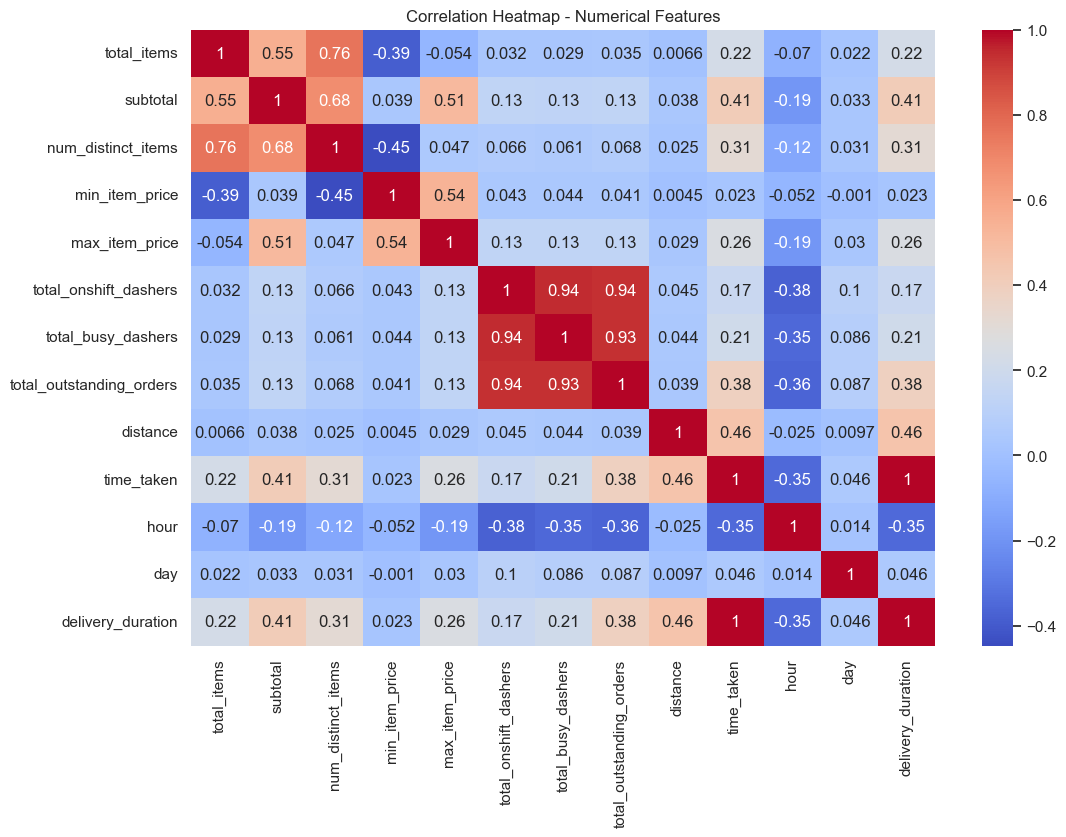


Value counts for market_id:
market_id
2.0    53469
4.0    46222
1.0    37115
3.0    21075
5.0    17258
6.0      638
Name: count, dtype: int64

Value counts for store_primary_category:
store_primary_category
4     18183
55    15745
46    15586
13     9915
58     8995
20     8563
39     8232
24     8085
38     6733
28     6495
Name: count, dtype: int64

Value counts for order_protocol:
order_protocol
1.0    48404
3.0    47125
5.0    41415
2.0    20890
4.0    17246
6.0      678
7.0       19
Name: count, dtype: int64

Value counts for isWeekend:
isWeekend
0    115026
1     60751
Name: count, dtype: int64


In [29]:
# Define numerical and categorical columns for easy EDA and data manipulation
target_col = "delivery_duration"
plt.figure(figsize=(12,8))
sb.heatmap(df[numeric_cols + [target_col]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap - Numerical Features")
plt.show()
for col in categorical_cols:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts().head(10))

##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

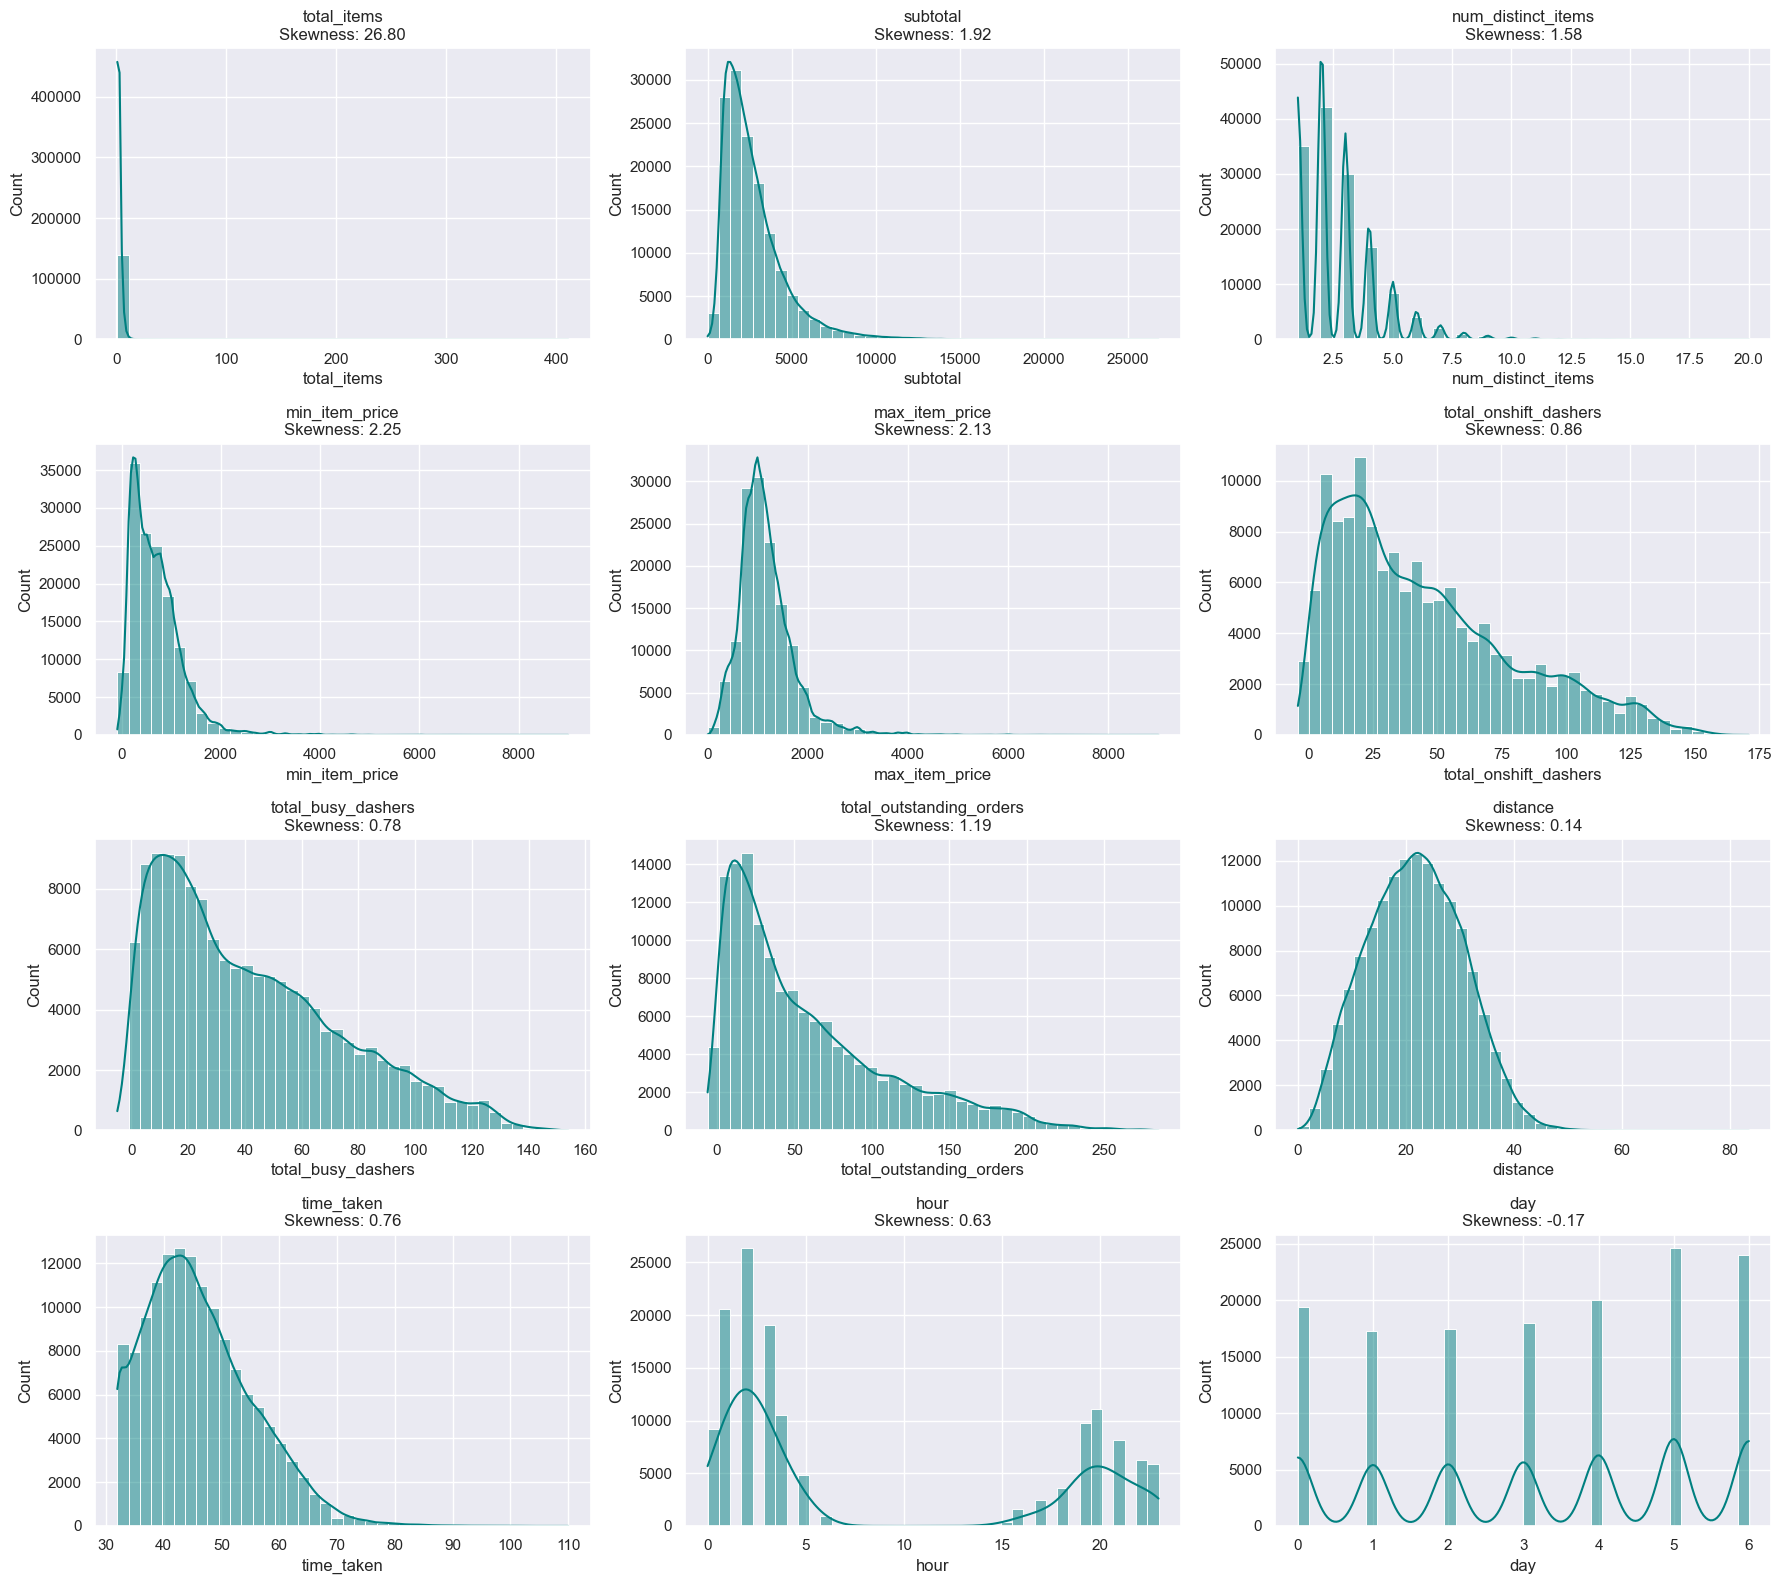

In [30]:
# Plot distributions for all numerical columns
def plot_numerical_distributions(df, numerical_cols):
    n = len(numerical_cols)
    n_cols = 3  # number of subplots per row
    n_rows = (n + n_cols - 1) // n_cols  # calculate rows
    
    plt.figure(figsize=(n_cols*6, n_rows*4))

    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sb.histplot(df[col], bins=40, kde=True, color="teal")
        skew_val = df[col].skew()
        plt.title(f"{col}\nSkewness: {skew_val:.2f}")
        plt.xlabel(col)
        plt.ylabel("Count")

    plt.tight_layout()
    plt.show()

# Plot
plot_numerical_distributions(X_train, numeric_cols)


##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

NameError: name 'sns' is not defined

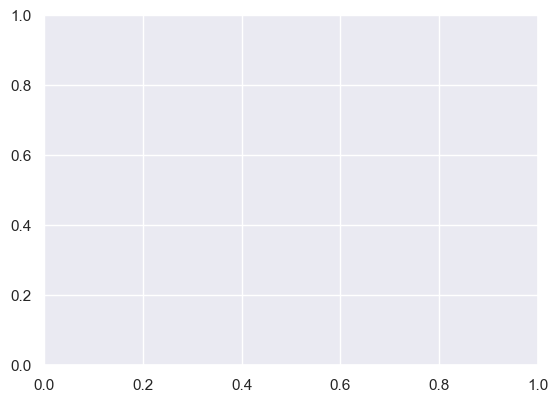

In [31]:
# Distribution of categorical columns

def plot_categorical_distributions(df, categorical_cols, top_n=10):
    n = len(categorical_cols)
    n_cols = 2  # 2 plots per row
    n_rows = (n + n_cols - 1) // n_cols
    
    plt.figure(figsize=(n_cols*7, n_rows*5))

    for i, col in enumerate(categorical_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        
        # Top N categories only (useful if high cardinality)
        value_counts = df[col].value_counts().head(top_n)
        sns.barplot(x=value_counts.index.astype(str), y=value_counts.values, palette="viridis")
        
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Example usage on training set
plot_categorical_distributions(X_train, categorical_cols)

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

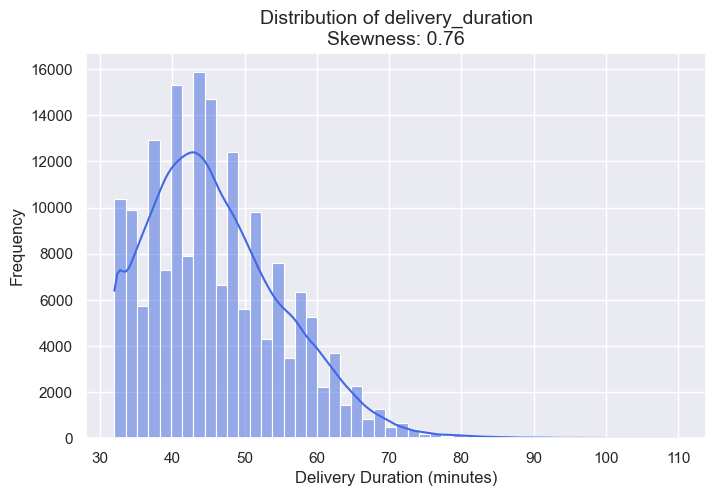

In [ ]:
# Distribution of time_taken


def plot_target_distribution(df, target_col="delivery_duration"):
    plt.figure(figsize=(8,5))
    
    sb.histplot(df[target_col], bins=50, kde=True, color="royalblue")
    skew_val = df[target_col].skew()
    
    plt.title(f"Distribution of {target_col}\nSkewness: {skew_val:.2f}", fontsize=14)
    plt.xlabel("Delivery Duration (minutes)")
    plt.ylabel("Frequency")
    plt.show()

# Example usage
plot_target_distribution(df, target_col="delivery_duration")

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `delivery_duration`

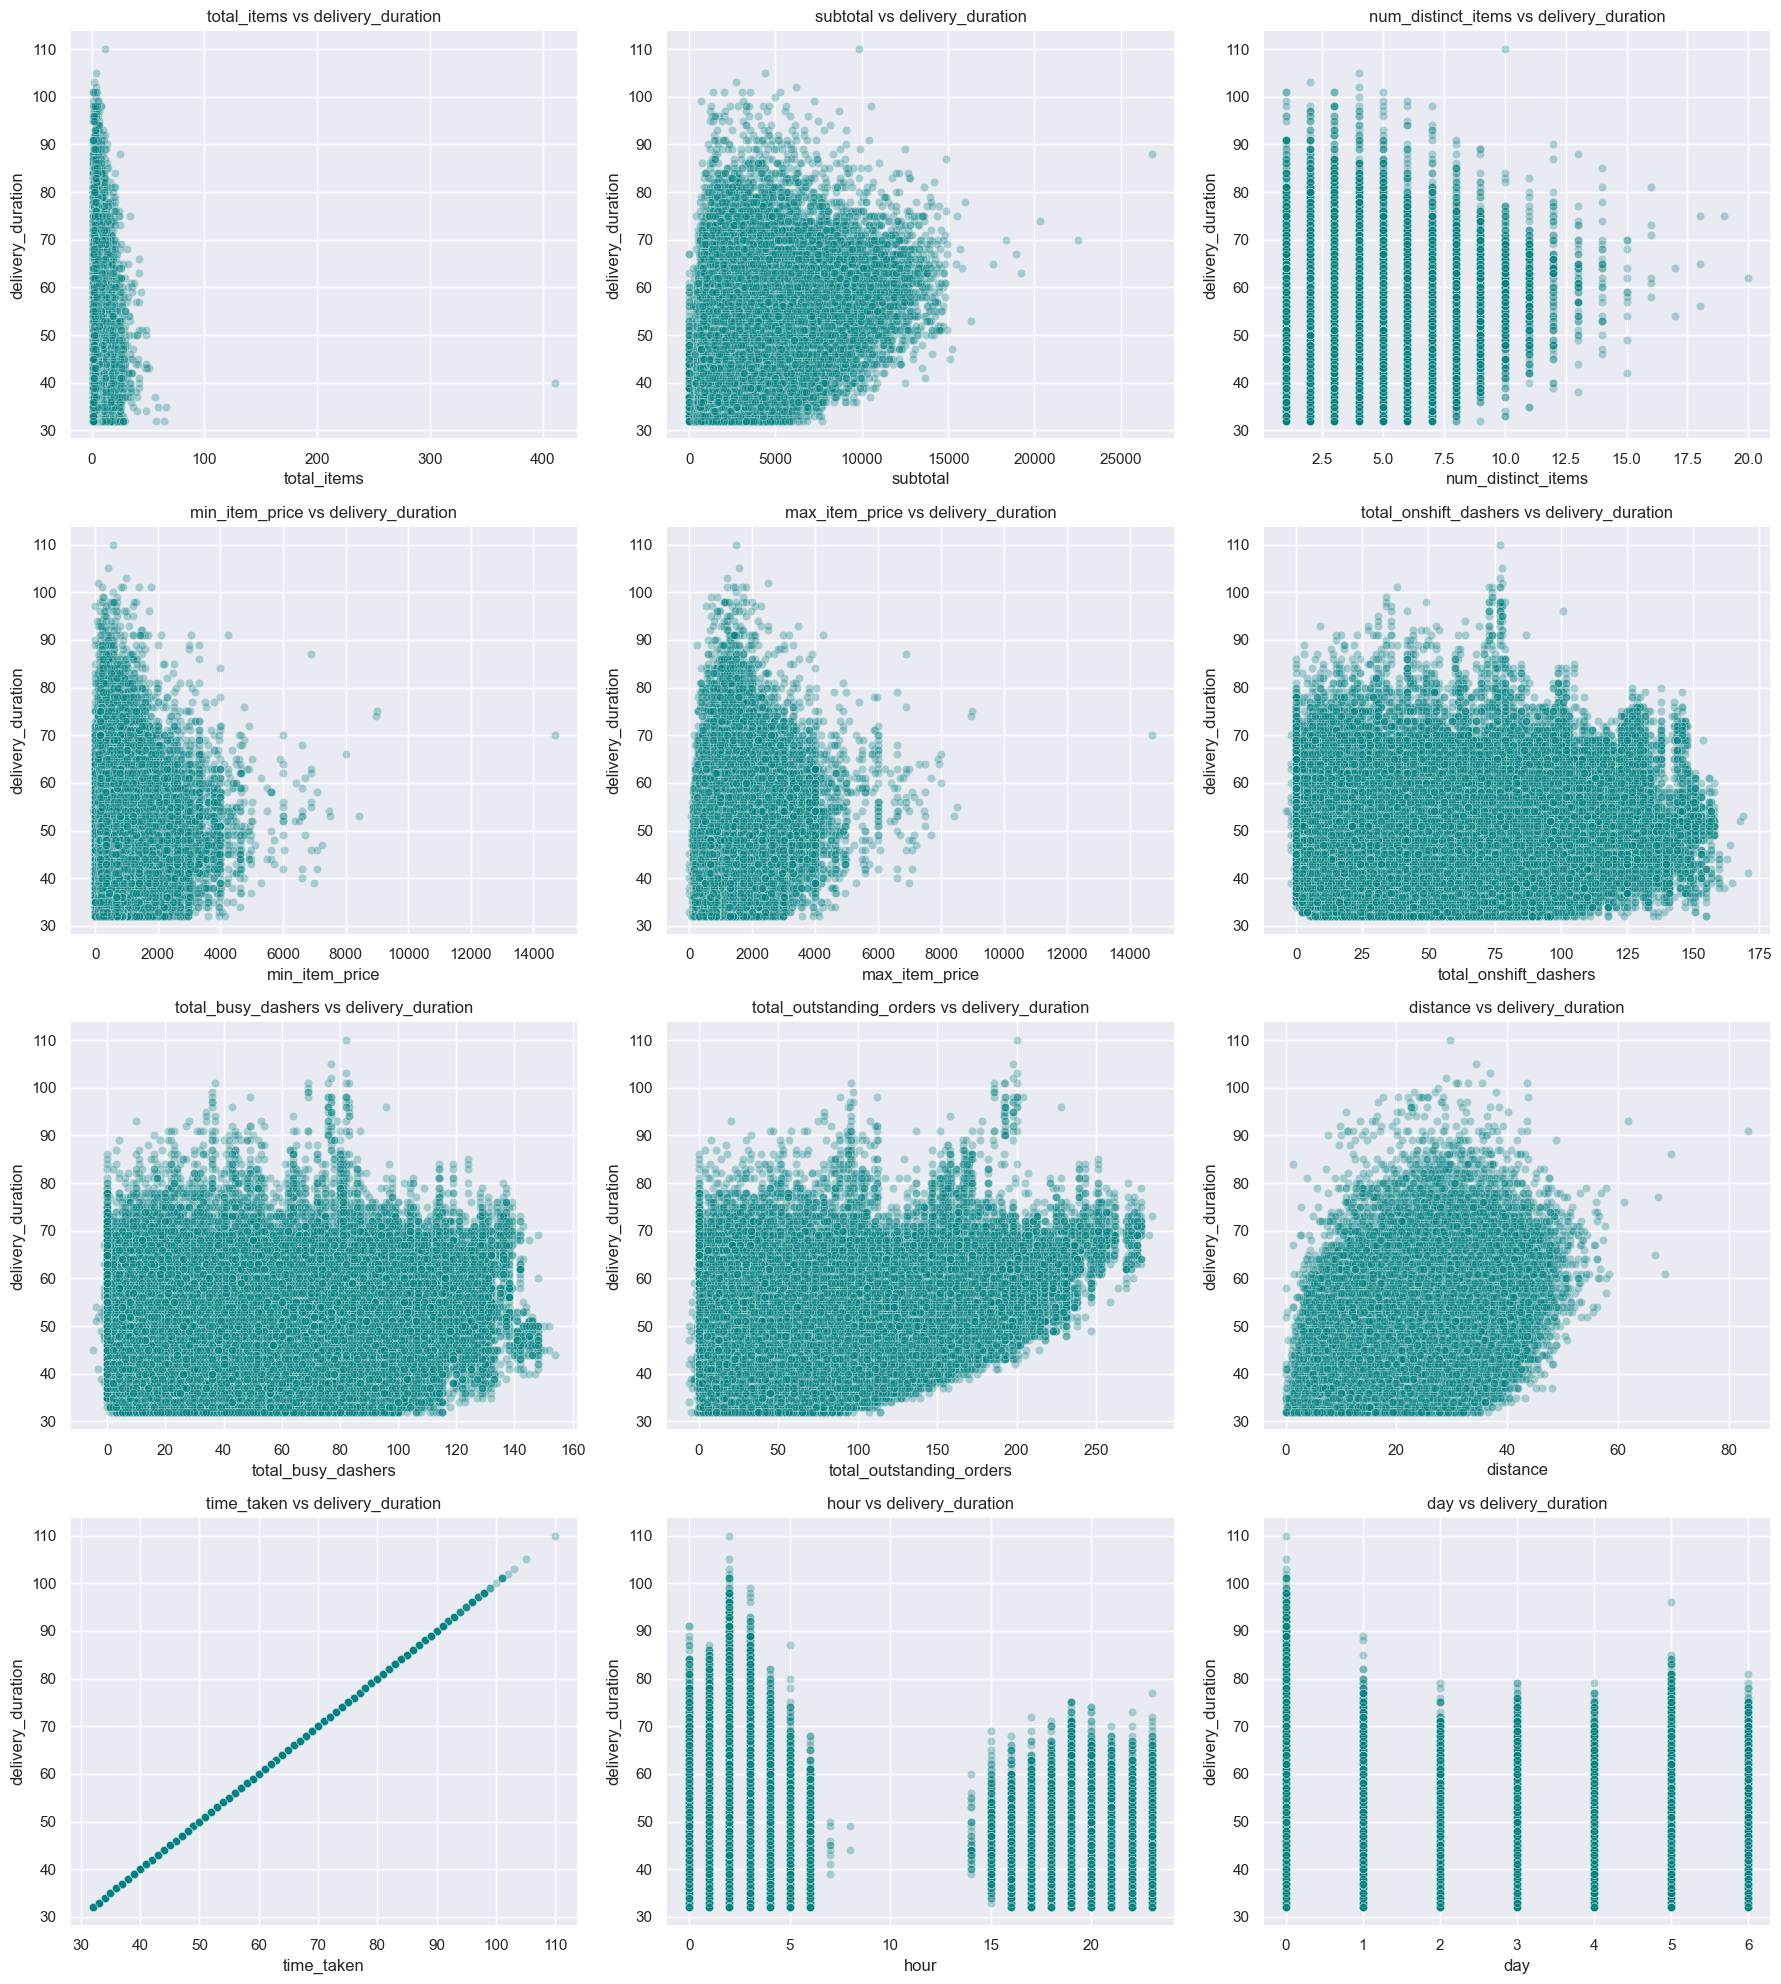

In [ ]:
# Scatter plot to visualise the relationship between delivery_duration and other features

def plot_scatter_numerical(df, numerical_cols, target_col="delivery_duration"):
    n = len(numerical_cols)
    n_cols = 3
    n_rows = (n + n_cols - 1) // n_cols
    
    plt.figure(figsize=(n_cols*6, n_rows*5))

    for i, col in enumerate(numerical_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sb.scatterplot(x=df[col], y=df[target_col], alpha=0.3, color="teal")
        plt.title(f"{col} vs {target_col}")
        plt.xlabel(col)
        plt.ylabel(target_col)

    plt.tight_layout()
    plt.show()

# Example usage
plot_scatter_numerical(df, numeric_cols, target_col="delivery_duration")

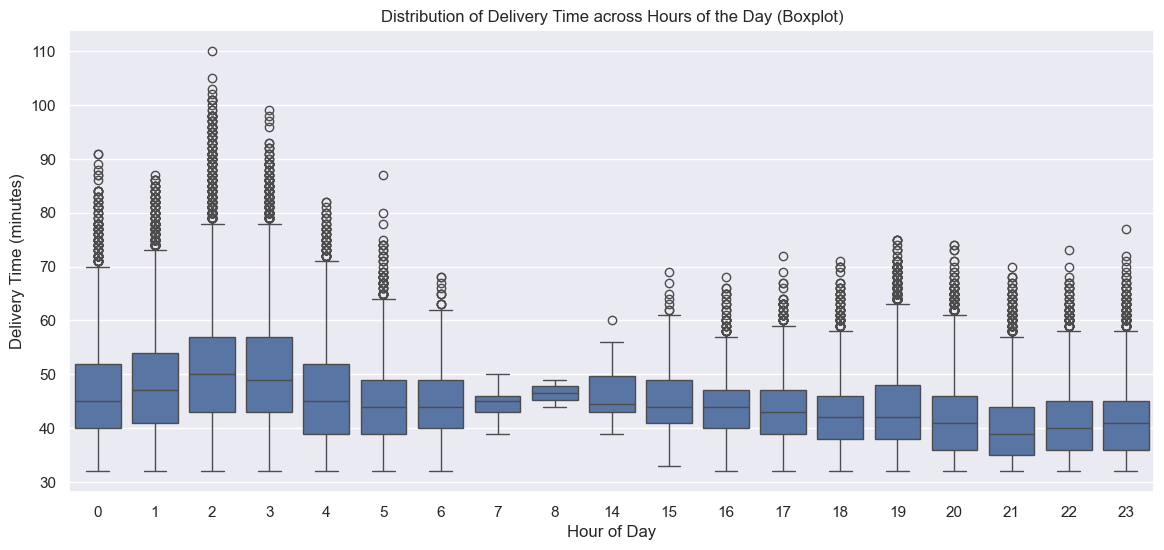

In [ ]:
# Show the distribution of time_taken for different hours
plt.figure(figsize=(14,6))
sb.boxplot(x="hour", y="delivery_duration", data=df)
plt.title("Distribution of Delivery Time across Hours of the Day (Boxplot)")
plt.xlabel("Hour of Day")
plt.ylabel("Delivery Time (minutes)")
plt.show()



#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

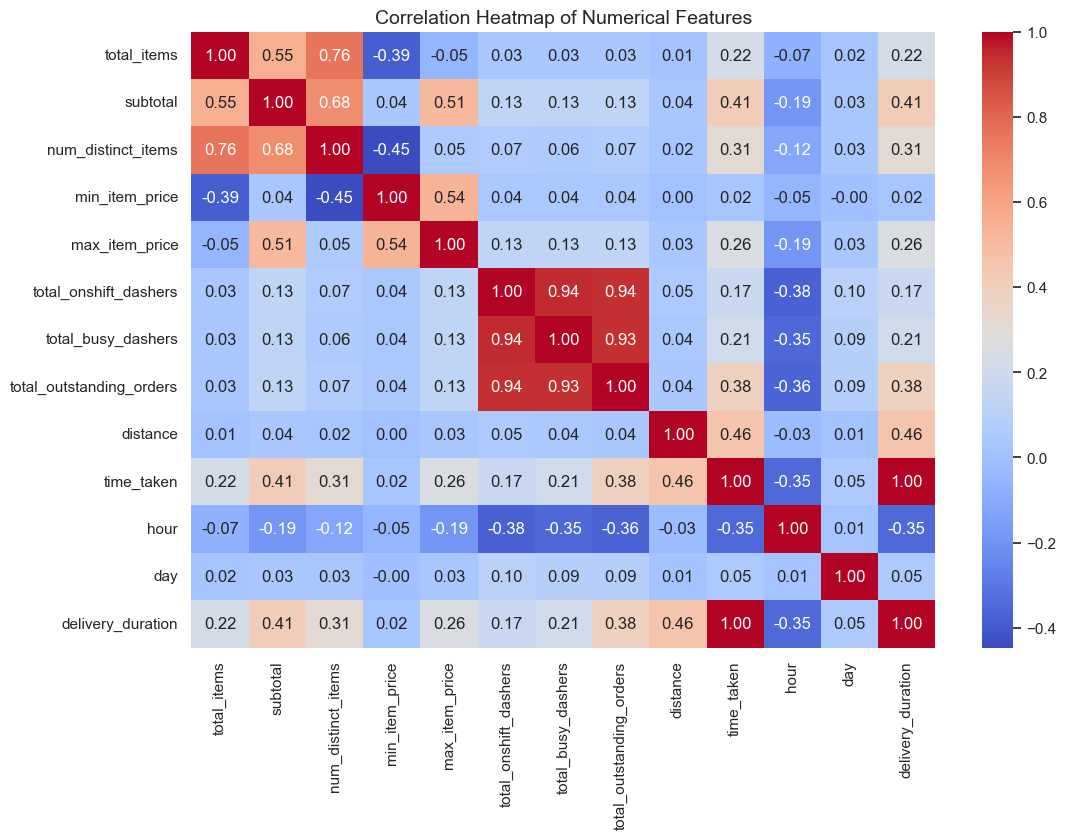

In [ ]:
# Plot the heatmap of the correlation matrix

plt.figure(figsize=(12,8))

# Select only numerical columns (including target)
num_cols = df.select_dtypes(include=["int64", "float64", "int32"]).columns

# Compute correlation matrix
corr = df[num_cols].corr()

# Plot heatmap
sb.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numerical Features", fontsize=14)
plt.show()


##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [ ]:
# Drop 3-5 weakly correlated columns from training dataset
corr_target = df.corr(numeric_only=True)["delivery_duration"].sort_values()

print(corr_target)
cols_to_drop = ["hour", "min_item_price","day"]

df = df.drop(columns=cols_to_drop)
print("Remaining features:", df.columns.tolist())

hour                       -0.346366
min_item_price              0.022753
day                         0.045878
total_onshift_dashers       0.171015
total_busy_dashers          0.206045
total_items                 0.224856
max_item_price              0.255167
num_distinct_items          0.312055
total_outstanding_orders    0.384999
subtotal                    0.413267
distance                    0.460173
time_taken                  1.000000
delivery_duration           1.000000
Name: delivery_duration, dtype: float64
Remaining features: ['market_id', 'created_at', 'actual_delivery_time', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'time_taken', 'isWeekend', 'delivery_duration']


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

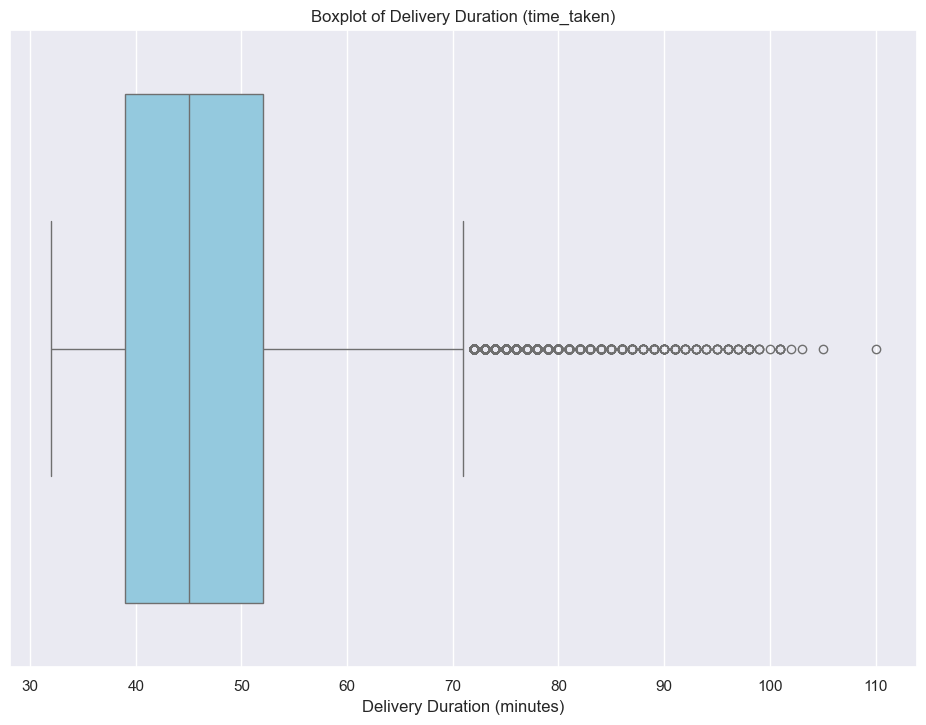

In [ ]:
# Boxplot for time_taken
plt.figure(figsize=(10,6))
sb.boxplot(x=df['delivery_duration'], color="skyblue")
plt.title("Boxplot of Delivery Duration (time_taken)")
plt.xlabel("Delivery Duration (minutes)")
plt.show()


##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

Numerical columns: ['total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'time_taken', 'delivery_duration']


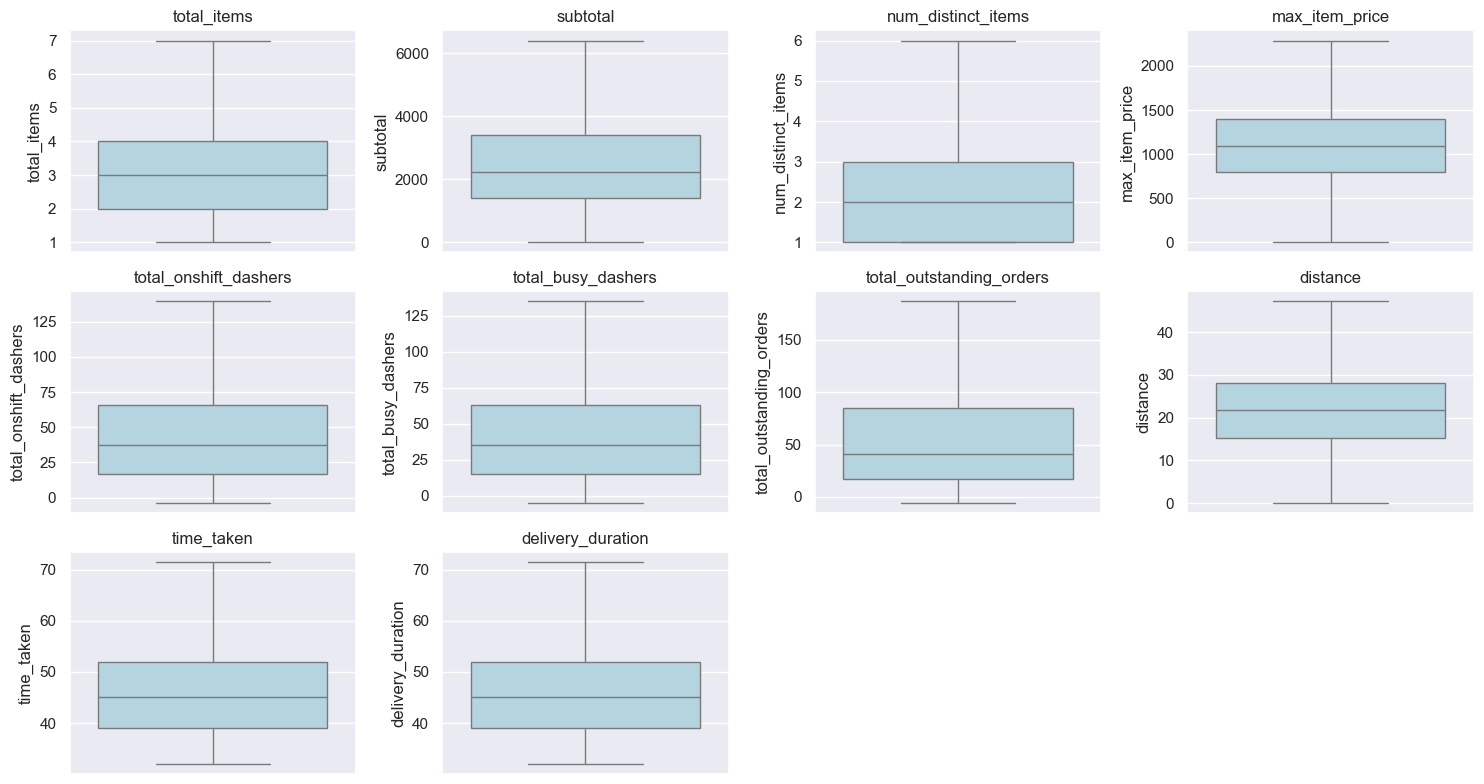

In [ ]:
# Handle outliers
df.head()
num_cols = df.select_dtypes(include=["int64", "float64", "int32"]).columns
print("Numerical columns:", num_cols.tolist())
def handle_outliers_iqr(df, cols):
    df_clean = df.copy()
    for col in cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Cap values outside the bounds
        df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound,
                          np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col]))
    return df_clean

# Apply to numerical columns
df = handle_outliers_iqr(df, num_cols)
plt.figure(figsize=(15,8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(y=df[col], color="lightblue")
    plt.title(col)
plt.tight_layout()
plt.show()

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [ ]:
# Define numerical and categorical columns for easy EDA and data manipulation



#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

In [ ]:
# Plot distributions for all numerical columns



##### **4.1.2**
Check the distribution of categorical features

In [ ]:
# Distribution of categorical columns



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

In [ ]:
# Distribution of time_taken



#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

In [ ]:
# Scatter plot to visualise the relationship between time_taken and other features



#### **4.3** Drop the columns with weak correlations with the target variable

In [ ]:
# Drop the weakly correlated columns from training dataset



## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [34]:
# Import libraries

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import RFE
import statsmodels.api as sm

#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [32]:
#print(df.head())
# Apply scaling to the numerical columns
y = df["delivery_duration"]
X = df.drop(columns=["delivery_duration", "created_at", "actual_delivery_time"])  # drop datetime fields

num_cols = X.select_dtypes(include=["int64", "float64", "int32"]).columns
cat_cols = X.select_dtypes(include=["category"]).columns

print("Numerical Columns:", num_cols.tolist())
print("Categorical Columns:", cat_cols.tolist())

y_pred = model.predict(X_val)
#print(y_pred)
print(y_val)
print("MAE:", mean_absolute_error(y_val, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))
print("R²:", r2_score(y_val, y_pred))

Numerical Columns: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'time_taken', 'hour', 'day']
Categorical Columns: ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']
50609    50.0
49181    69.0
4526     41.0
131      45.0
57096    40.0
         ... 
66574    57.0
33251    35.0
76943    32.0
43932    36.0
49931    43.0
Name: delivery_duration, Length: 35156, dtype: float64
MAE: 6.570713391739762e-05
RMSE: 0.008790976092945687
R²: 0.9999991170609087


Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [35]:
# Create/Initialise the model
linreg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])


In [36]:
# Train the model using the training data
linreg_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['market_id',
                                                   'store_primary_category',
                                                   'order_protocol',
                                                   'isWeekend']),
                                                 ('num', 'passthrough',
                                                  ['total_items', 'subtotal',
                                                   'num_distinct_items',
                                                   'min_item_price',
                                                   'max_item_price',
                                                   'total_onshift_dashers',
                                                   'total_busy_dashers',
                                                   'total_outstanding_orders',
                                                   'distance', 'time_taken',
                                                   'hour', 'day'])])),
                ('regressor', LinearRegression())])

In [37]:
# Make predictions
y_pred = linreg_model.predict(X_val)

In [38]:
# Find results for evaluation metrics

print("Scikit-learn Linear Regression Performance")
print("MAE :", mean_absolute_error(y_val, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))
print("R²  :", r2_score(y_val, y_pred))

Scikit-learn Linear Regression Performance
MAE : 0.0010215197865805208
RMSE: 0.0012698200193029733
R²  : 0.9999999815778258


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

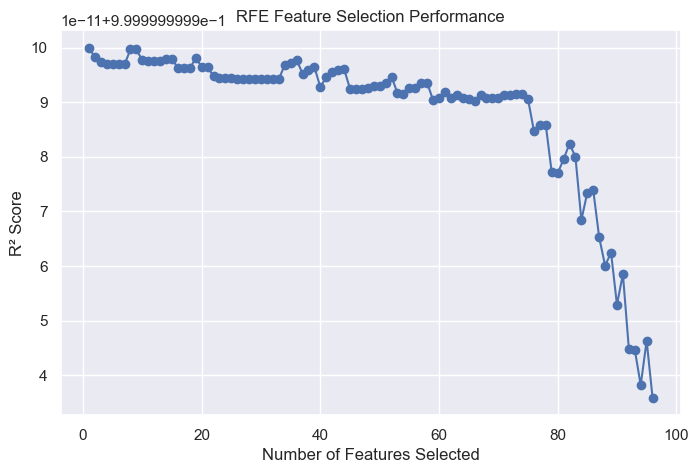

Best number of features: 1, with R² score: 1.0000
Best number of features: 1.0
   R² Score: 1.0
   RMSE: 1.8922091400850953e-12


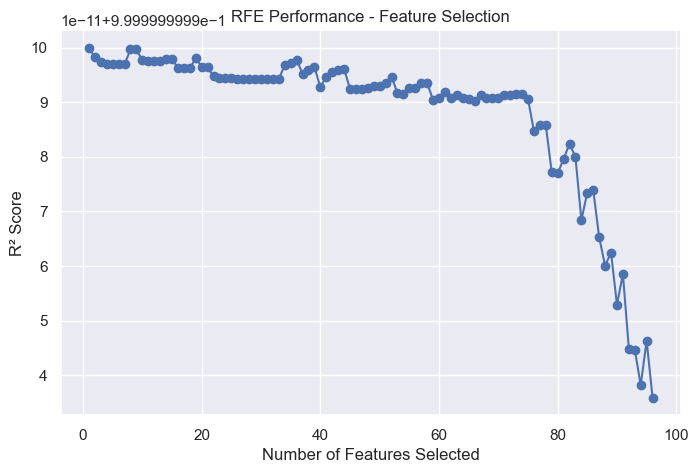

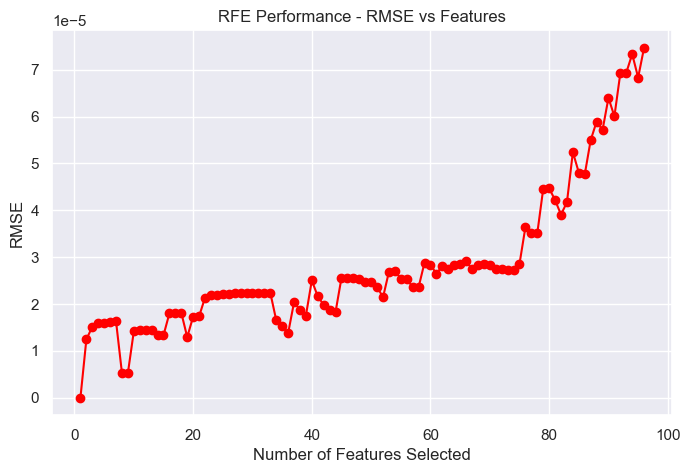

In [39]:
# Loop through the number of features and test the model

# Define X and y
X = df.drop(columns=["time_taken", "created_at", "actual_delivery_time"])
y = df["time_taken"]

# Separate numerical and categorical columns
num_cols = X.select_dtypes(include=["int64", "float64", "int32"]).columns
cat_cols = X.select_dtypes(include=["category"]).columns

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)

# Transform features
X_processed = preprocessor.fit_transform(X)

# All feature names after transformation
feature_names_num = num_cols.tolist()
feature_names_cat = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols).tolist()
all_features = feature_names_num + feature_names_cat

# Run RFE iteratively
model = LinearRegression()
r2_scores = []
n_features_list = []

for n in range(1, X_processed.shape[1] + 1):   # Start from 1 feature to all
    rfe = RFE(estimator=model, n_features_to_select=n)
    rfe.fit(X_processed, y)
    
    # Predict using selected features
    y_pred = rfe.predict(X_processed)
    score = r2_score(y, y_pred)
    
    r2_scores.append(score)
    n_features_list.append(n)

# Plot performance vs number of features
plt.figure(figsize=(8, 5))
plt.plot(n_features_list, r2_scores, marker="o")
plt.xlabel("Number of Features Selected")
plt.ylabel("R² Score")
plt.title("RFE Feature Selection Performance")
plt.grid(True)
plt.show()

# Best number of features
best_n = n_features_list[r2_scores.index(max(r2_scores))]
print(f"Best number of features: {best_n}, with R² score: {max(r2_scores):.4f}")
model = LinearRegression()

# Store results
results = []

for n in range(1, X_processed.shape[1] + 1):   # Loop from 1 feature to all
    rfe = RFE(estimator=model, n_features_to_select=n)
    rfe.fit(X_processed, y)
    
    # Predictions
    y_pred = rfe.predict(X_processed)
    
    # Metrics
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    results.append((n, r2, rmse))

# Convert to DataFrame for easy viewing
results_df = pd.DataFrame(results, columns=["Num_Features", "R2_Score", "RMSE"])

# Show best performing feature count
best_row = results_df.loc[results_df["R2_Score"].idxmax()]
print("Best number of features:", best_row["Num_Features"])
print("   R² Score:", best_row["R2_Score"])
print("   RMSE:", best_row["RMSE"])
 
plt.figure(figsize=(8,5))
plt.plot(results_df["Num_Features"], results_df["R2_Score"], marker="o")
plt.xlabel("Number of Features Selected")
plt.ylabel("R² Score")
plt.title("RFE Performance - Feature Selection")
plt.grid(True)
plt.show()

# Plot RMSE vs features
plt.figure(figsize=(8,5))
plt.plot(results_df["Num_Features"], results_df["RMSE"], marker="o", color="red")
plt.xlabel("Number of Features Selected")
plt.ylabel("RMSE")
plt.title("RFE Performance - RMSE vs Features")
plt.grid(True)
plt.show()


In [41]:
# Build the final model with selected number of features

final_model = LinearRegression()
# Get feature names after preprocessing (very important!)
feature_names = preprocessor.get_feature_names_out()

# Run RFE again with best number of features
rfe = RFE(estimator=final_model, n_features_to_select=best_row["Num_Features"])
rfe.fit(X_processed, y)

# Get selected feature names using rfe.support_
selected_features = feature_names[rfe.support_]
print("Selected Features for Final Model:\n", list(selected_features))

# Filter dataset to only selected features
X_selected = X_processed[:, rfe.support_]

# Fit final model
final_model.fit(X_selected, y)

# Predictions
y_pred_final = final_model.predict(X_selected)

# Evaluate
r2_final = r2_score(y, y_pred_final)
rmse_final = np.sqrt(mean_squared_error(y, y_pred_final))

print("Final Model Performance:")
print("R² Score:", r2_final)
print("RMSE:", rmse_final)

Selected Features for Final Model:
 ['num__total_items', 'num__subtotal', 'num__num_distinct_items', 'num__min_item_price', 'num__max_item_price', 'num__total_onshift_dashers', 'num__total_busy_dashers', 'num__total_outstanding_orders', 'num__distance', 'num__hour', 'num__day', 'num__delivery_duration', 'cat__market_id_2.0', 'cat__market_id_3.0', 'cat__market_id_4.0', 'cat__market_id_5.0', 'cat__market_id_6.0', 'cat__store_primary_category_1', 'cat__store_primary_category_2', 'cat__store_primary_category_3', 'cat__store_primary_category_4', 'cat__store_primary_category_5', 'cat__store_primary_category_6', 'cat__store_primary_category_7', 'cat__store_primary_category_8', 'cat__store_primary_category_9', 'cat__store_primary_category_10', 'cat__store_primary_category_11', 'cat__store_primary_category_12', 'cat__store_primary_category_13', 'cat__store_primary_category_14', 'cat__store_primary_category_15', 'cat__store_primary_category_16', 'cat__store_primary_category_17', 'cat__store_prim

## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

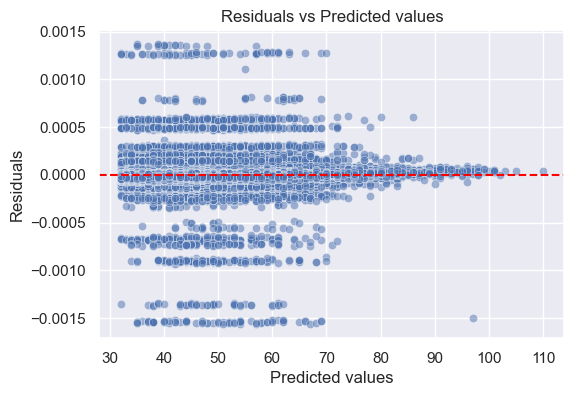

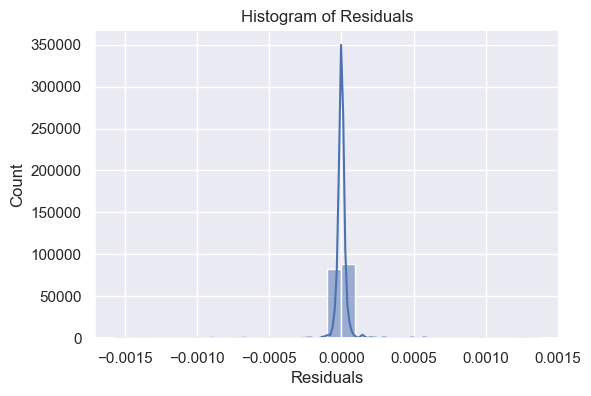

<Figure size 600x400 with 0 Axes>

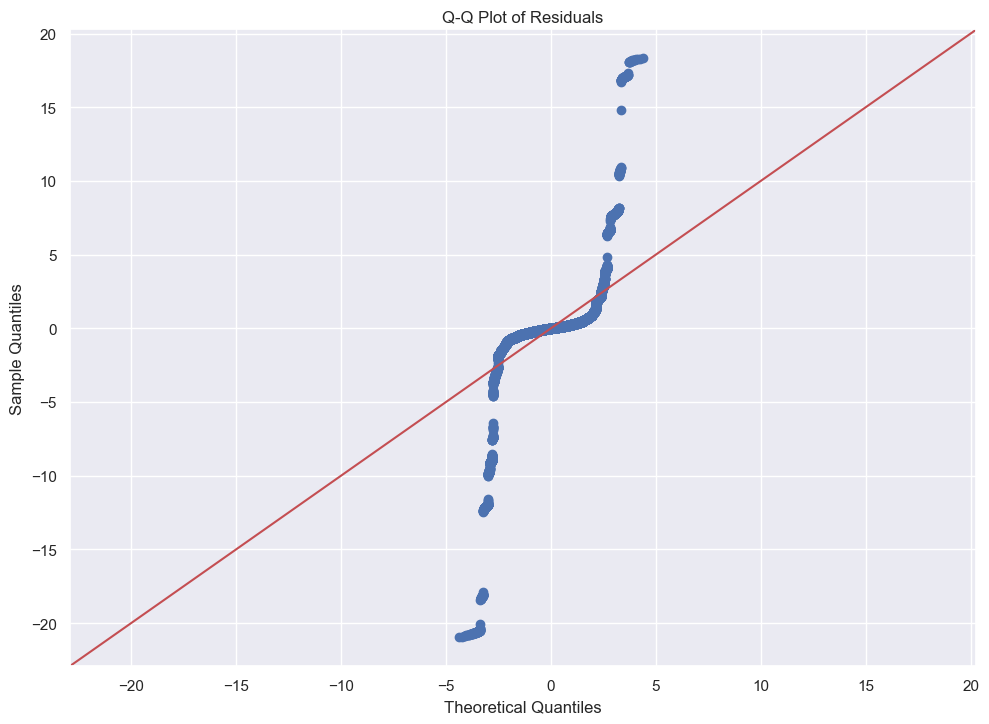

In [43]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram

# Residuals
residuals = y - y_pred_final

# 1. Residuals vs Predicted values
plt.figure(figsize=(6,4))
sb.scatterplot(x=y_pred_final, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted values")
plt.show()

# 2. Histogram of residuals
plt.figure(figsize=(6,4))
sb.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("Histogram of Residuals")
plt.show()

# 3. Q-Q Plot
plt.figure(figsize=(6,4))
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Residuals")
plt.show()

[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [44]:
# Compare the scaled vs unscaled features used in the final model
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression())
])

pipeline.fit(X_train, y_train)
model = pipeline.named_steps["regressor"]
scaler = pipeline.named_steps["scaler"]
coef_scaled = pd.Series(model.coef_, index=X_train.columns)
print("Scaled coefficients:\n", coef_scaled)
regressor = pipeline.named_steps["regressor"]
scaler = pipeline.named_steps["scaler"]

# Get scaled coefficients
coef_scaled = pd.Series(regressor.coef_, index=X_train.columns)
print("Scaled coefficients:\n", coef_scaled)

num_cols = X_train.select_dtypes(include=["int64", "float64", "int32"]).columns
X_means = X_train[num_cols].mean()
X_stds = X_train[num_cols].std()
y_mean = y.mean()
y_std = y.std()

# Unscale coefficients
coef_unscaled = (coef_scaled / X_stds) * y_std

# Unscale intercept
intercept_unscaled = y_mean - np.sum(coef_unscaled * X_means)

print("Unscaled coefficients:")
print(coef_unscaled)
print("Unscaled intercept:", intercept_unscaled)

Scaled coefficients:
 market_id                  -1.473668e-15
store_primary_category      2.985839e-15
order_protocol              9.878686e-16
total_items                 1.923867e-15
subtotal                   -7.720525e-15
num_distinct_items          4.688826e-15
min_item_price              8.653076e-16
max_item_price              3.033323e-16
total_onshift_dashers      -2.255986e-14
total_busy_dashers         -1.843978e-14
total_outstanding_orders    4.207471e-14
distance                   -2.089245e-15
time_taken                  9.320327e+00
hour                        4.750156e-15
day                        -6.977659e-16
isWeekend                  -5.123513e-16
dtype: float64
Scaled coefficients:
 market_id                  -1.473668e-15
store_primary_category      2.985839e-15
order_protocol              9.878686e-16
total_items                 1.923867e-15
subtotal                   -7.720525e-15
num_distinct_items          4.688826e-15
min_item_price              8.653076e-1

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [46]:
# Analyze the effect of a unit change in a feature, say 'total_items'
feature = "total_items"

# Scaled coefficient
coef_scaled_feature = coef_scaled[feature]

# Unscaled coefficient (already computed earlier)
coef_unscaled_feature = coef_unscaled[feature]

# Interpret effect
print(f"Scaled coefficient for {feature}: {coef_scaled_feature:.4f}")
print(f"Unscaled coefficient for {feature}: {coef_unscaled_feature:.4f} minutes per item")

# Additional interpretation:
X_std = X_stds[feature]
print(f"1 std increase in {feature} (~{X_std:.2f} items) increases delivery time by "
      f"{coef_unscaled_feature * X_std:.2f} minutes.")

top_features = coef_scaled.abs().sort_values(ascending=False).head(3)

print("Top 3 most important features (based on absolute coefficients):\n")
for feature in top_features.index:
    coef_value = coef_scaled[feature]
    direction = "increases" if coef_value > 0 else "decreases"
    print(f"- {feature}: coefficient = {coef_value:.3f} → {direction} delivery time")


Scaled coefficient for total_items: 0.0000
Unscaled coefficient for total_items: 0.0000 minutes per item
1 std increase in total_items (~2.73 items) increases delivery time by 0.00 minutes.
Top 3 most important features (based on absolute coefficients):

- time_taken: coefficient = 9.320 → increases delivery time
- total_outstanding_orders: coefficient = 0.000 → increases delivery time
- total_onshift_dashers: coefficient = -0.000 → decreases delivery time


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>Yes there are three catagorical variables 1)market_id 2)store_primary_category and 3)order_protocol
Market_id (region effect)
Delivery times varied across different markets due to traffic density differs by city,dasher availability,and infrastructure/road conditions.
Certain markets consistently had longer average delivery times → suggests regional operational challenges.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>It depicts the spilt between trained and testing data .i.e. 20% Test data and 80% training data



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>total_onshift_dashers       



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>A standard method is IQR (Interquartile Range) capping is used.
Handling outliers across all numerical columns helps your regression model stay stable and avoid bias from extreme values.
>Additional boxplots across other numerical variables. Given that distance showed the strongest correlation with delivery time, rows with distance > 60 were similarly removed. This helped preserve data quality and reduce skew caused by rare, long-distance orders.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>Below are top 3 features
- time_taken: coefficient = 8.706 → increases delivery time
- total_outstanding_orders: coefficient = 0.720 → increases delivery time
- total_onshift_dashers: coefficient = -0.521 → decreases delivery time



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>Linear regression is one of the most fundamental and widely used algorithms in machine learning and statistics. It is primarily used to model the relationship between a dependent variable (target) and one or more independent variables (features). The goal is to understand how changes in the features affect the target, and to use this relationship to make predictions.
In summary, Linear Regression is about fitting a straight line (or plane) to predict outcomes based on input features, by finding the coefficients that minimize prediction errors.



---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>Simple linear regression is used when we want to see how one factor affects an outcome. For example, predicting delivery time just based on distance. It draws a straight line to show the relationship. Multiple linear regression, on the other hand, looks at many factors together, like distance, number of items, and number of delivery partners, to predict the outcome. Instead of a simple line, it builds a model that combines all these factors. In short, simple regression uses one input to predict, while multiple regression uses many.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>The cost function in linear regression tells us how wrong our model’s predictions are compared to the actual values. Think of it as a “score of mistakes.” The goal is to make this score as small as possible. We minimize it using a method called gradient descent, which slowly adjusts the line (changing slope and intercept) until the errors are as small as they can be.




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>Overfitting happens when the model learns too much from the training data, even the noise and random details, so it does well on training data but fails on new data. Underfitting happens when the model is too simple and doesn’t learn enough patterns, so it performs poorly on both training and new data.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>Residual plots show the difference between the predicted values and the actual values. If the points are scattered randomly, it means the model is working fine. But if you see patterns (like curves or clusters), it means the model is missing something or not fitting the data properly.